Training (or old running calculations) are banished from this notebook!

In [ ]:
# Data Setup / Imports
from magrec import __logpath__, __datapath__

from copy import deepcopy
import inspect  # to print source code of a function


import numpy as np
import pandas as pd
import pyvista as pv
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F

import tqdm

import pytorch_lightning as L

from magrec.nn.modules import GaussianFourierFeaturesTransform, UniformFourierFeaturesTransform, RegularFourierFeaturesTransform
from magrec.nn.models import FourierFeaturesNd, WireNet
from magrec.nn.utils import batched_curl, batched_div, batched_grad, save_model_for_experiment, load_model_for_experiment

from magrec.misc.data import MagneticFieldUnstructuredGrid, MagneticFieldImageData

from magrec.misc.plot import plot_n_components, plot_vector_field_2d, plot_check_aligned_data
from magrec.prop.constants import twopi
from magrec.prop.Propagator import CurrentPropagator2d

from magrec.misc.sampler import GridSampler, NDGridPoints
from magrec.nn.utils import (
    rotate_vector_field_2d, 
    get_ckpt_path_by_regexp, 
    load_model_from_ckpt,
    reshape_rect,
)
    
import k3d
import vedo
vedo.settings.default_backend= "k3d"

from magrec.nn.experiments import (
    ExperimentConfig,
    JerschowExperiment, 
    JerschowExperimentConfig, 
    JerschowExperimentDenoise, 
    JerschowExperimentLearnB,
    JerschowExperimentLearnDecayB,
    JerschowExperimentLearnBRandomPts,
    )

In [2]:
config = JerschowExperimentConfig('Sine_wire.txt',
                                  model_params=dict(n_inputs=3, n_outputs=3, 
                                                    ff_stds=[(0.1, 10), (2, 5), (3, 5)]),
                                  data_batch_size=1000,
                                  batch_size=1000,
                                  decay_batch_size=2000,
                                  lr=1e-2,
                                  nz_points=100,
                                  eps_curl=1,
                                  eps_data=1,
                                  eps_div=1,)

experiment = JerschowExperimentDenoise(config)
experiment.load_data()
experiment = load_model_for_experiment(experiment, __datapath__ / "the_best_model_1.pt")

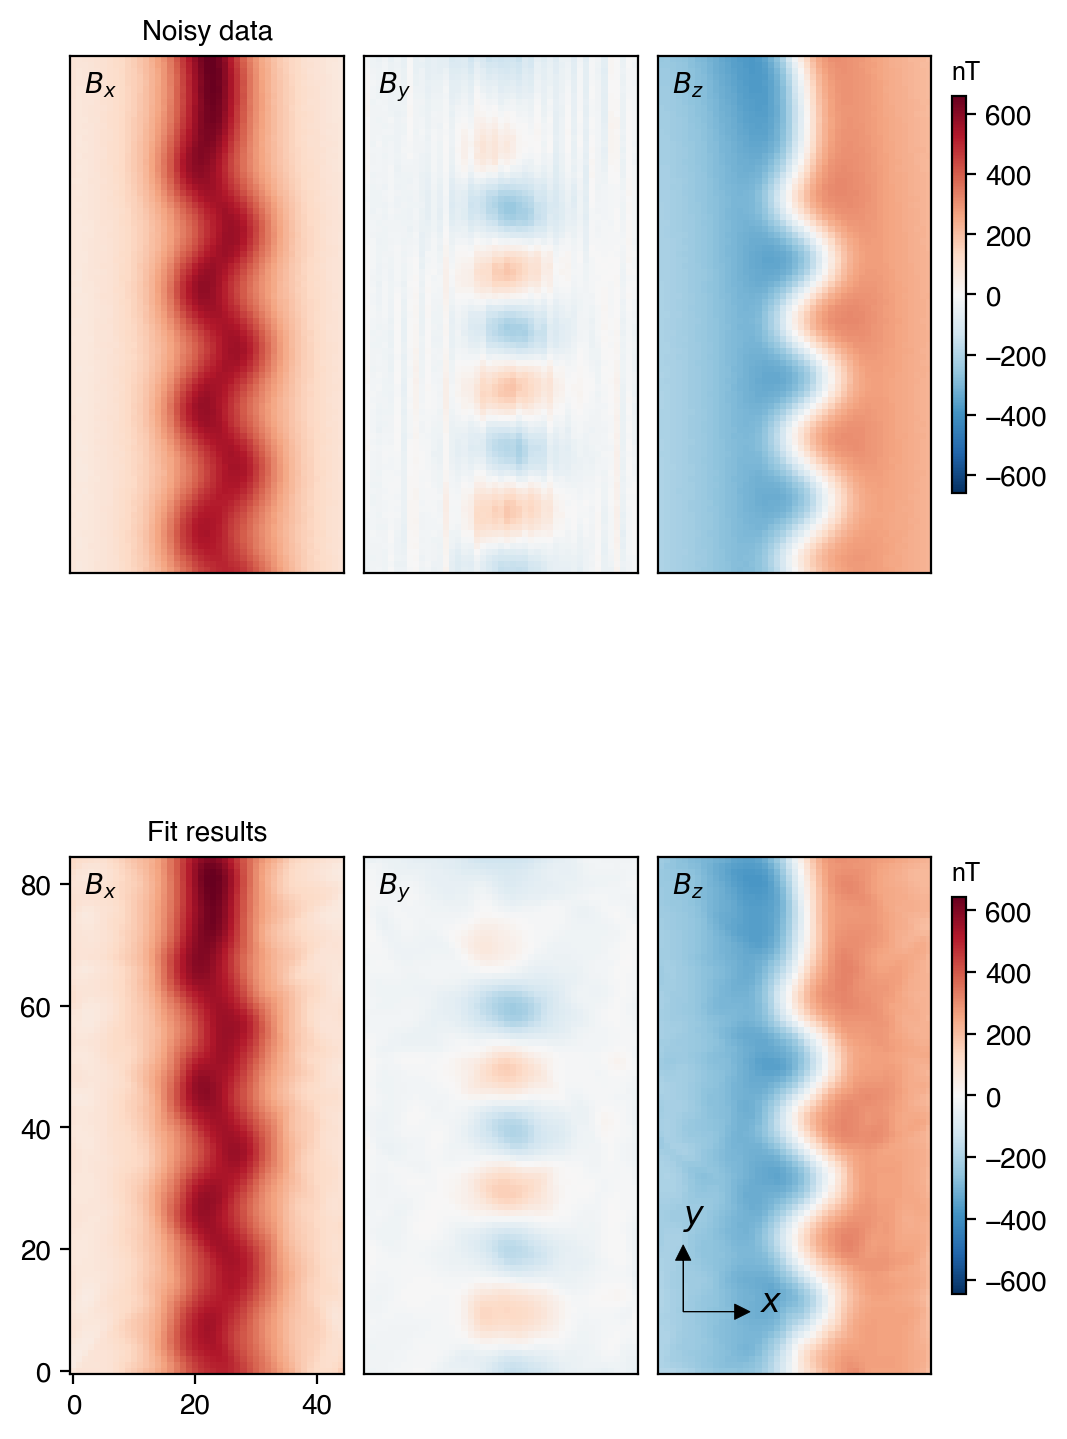

In [9]:
experiment.plot_results()

In [7]:
B_vectors = experiment.model.get_ffs_as_vectors()

In [8]:
vectors = k3d.vectors(np.zeros_like(B_vectors), B_vectors)

In [ ]:
vectors

Output()

In [3]:
wn = WireNet(learnable_I=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


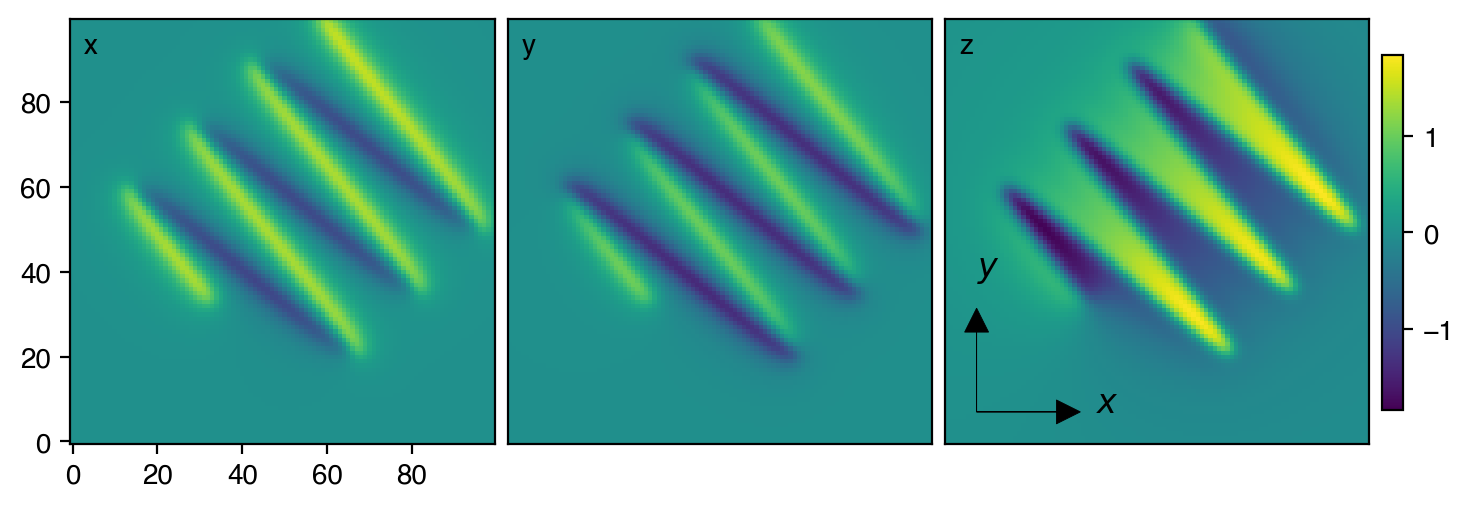

In [7]:
wn.net.I = torch.nn.Parameter(torch.Tensor([1.]))
plane_pos = GridSampler.sample_grid(100, 100, origin=[-1, -1], diagonal=[2, 2], z=0.1)
plane_pos = plane_pos.numpy()

# temporarily set wn.net to be a test path like this:
def test_path(s):
    r = torch.cat([2*s, torch.sin(20*s)], dim=1)
    r = rotate_vector_field_2d(r, 45 / 360 * 2 * torch.pi)
    return r

original_forward = wn.net.forward
try:
    wn.net.forward = test_path

    B2 = wn.get_B(pos=plane_pos)
    B2 = GridSampler.pts_to_grid(B2, 100, 100)

    fig = plot_n_components(B2)
finally:
    wn.net.forward = original_forward
    
plot_n_components(B2)


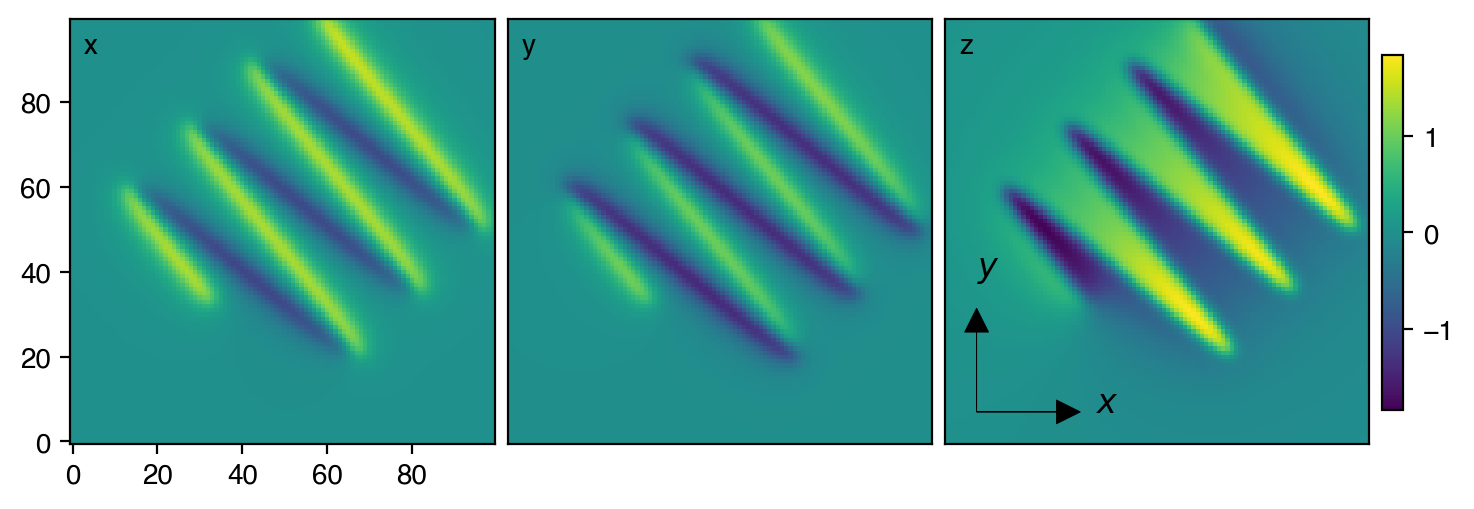

In [8]:
wn.net.I = torch.nn.Parameter(torch.Tensor([1.]))
plane_pos = GridSampler.sample_grid(100, 100, origin=[-1, -1], diagonal=[2, 2], z=0.1)
plane_pos = plane_pos.numpy()

# temporarily set wn.net to be a test path like this:
def test_path(s):
    r = torch.cat([2*s, torch.sin(20*s)], dim=1)
    r = rotate_vector_field_2d(r, 45 / 360 * 2 * torch.pi)
    return r

original_forward = wn.net.forward
try:
    wn.net.forward = test_path

    B1 = wn.get_B_magpylib(pos=plane_pos)
    B1 = GridSampler.pts_to_grid(B1, 100, 100)

    fig = plot_n_components(B1)
finally:
    wn.net.forward = original_forward
    
plot_n_components(B1)


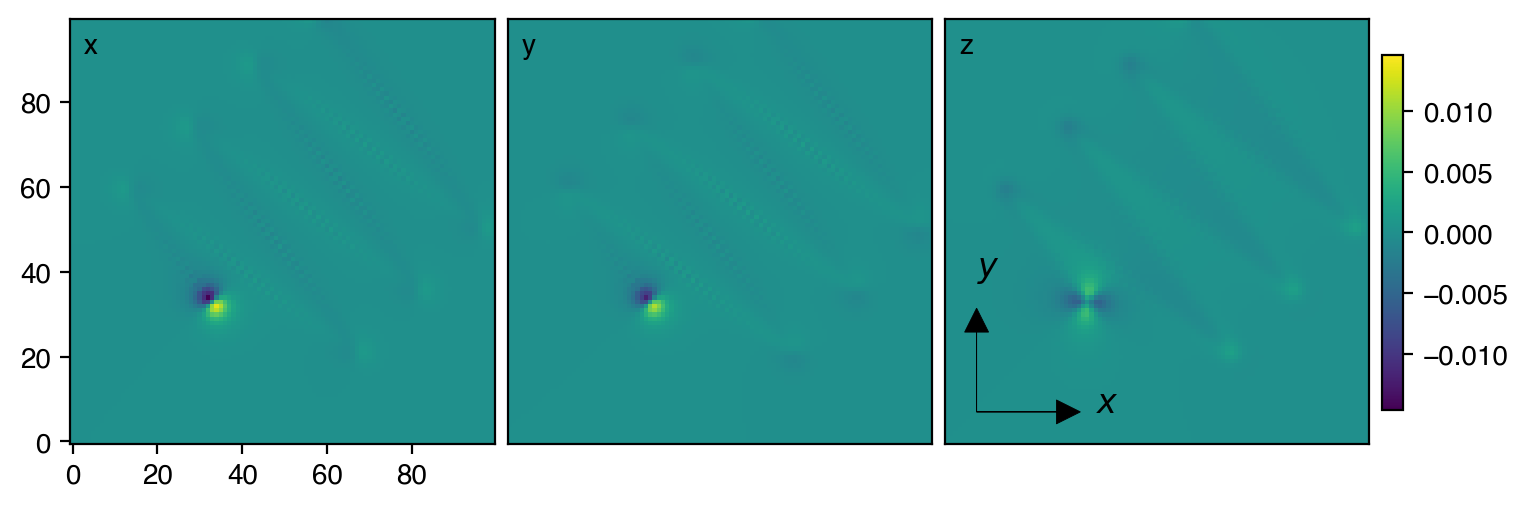

In [9]:
plot_n_components(B1 - B2)

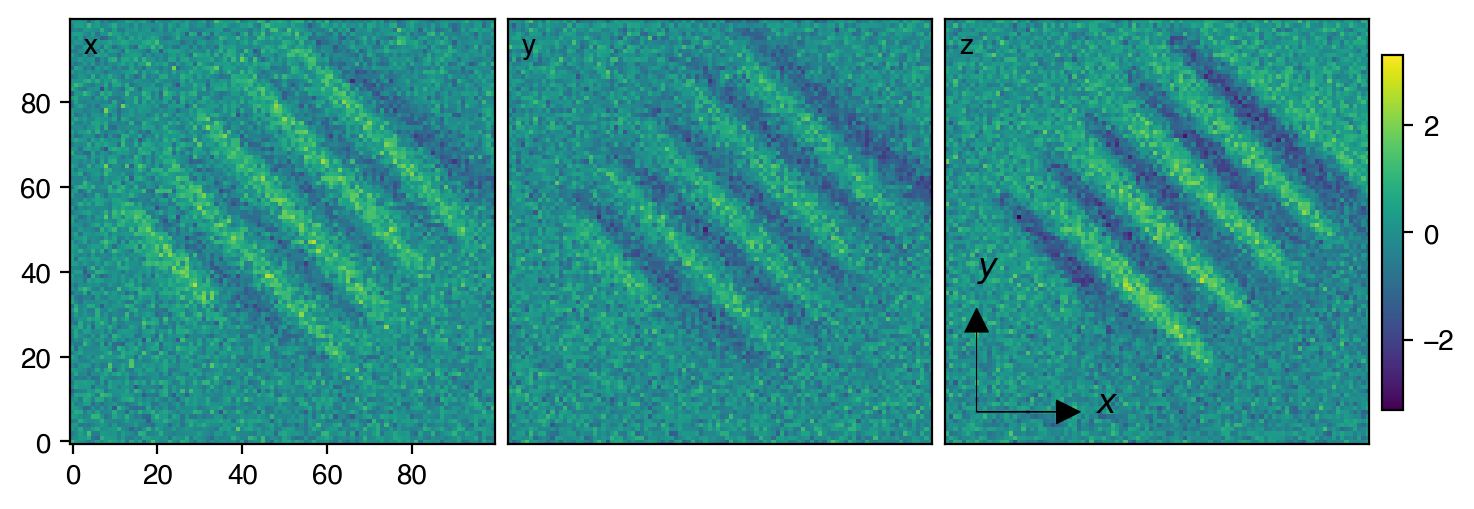

In [7]:
# Generate simulated field data using B1 field with added Gaussian noise of amplitude 0.5
field = B1.numpy()
field = field + np.random.normal(0, 0.5, field.shape)

# Show the noisy data
plot_n_components(field)

In [21]:
# use pyvista to create a simple grid
grid = pv.ImageGridSource(extent=(0, 100, 0, 100, 10, 10), spacing=(0.01, 0.01, 0.01)).output
grid.point_data.clear()
grid["B"] = wn.set_path_once(test_path).get_B(grid.points).detach()

In [ ]:
# use pyvista to create a simple grid
grid = pv.Plane(center=(1, 1, 0.1), direction=(0, 0, 1), i_size=4, j_size=4, i_resolution=100, j_resolution=100)
grid.point_data.clear()
# grid["B"] = wn.set_path_once(test_path).get_B(grid.points).detach()

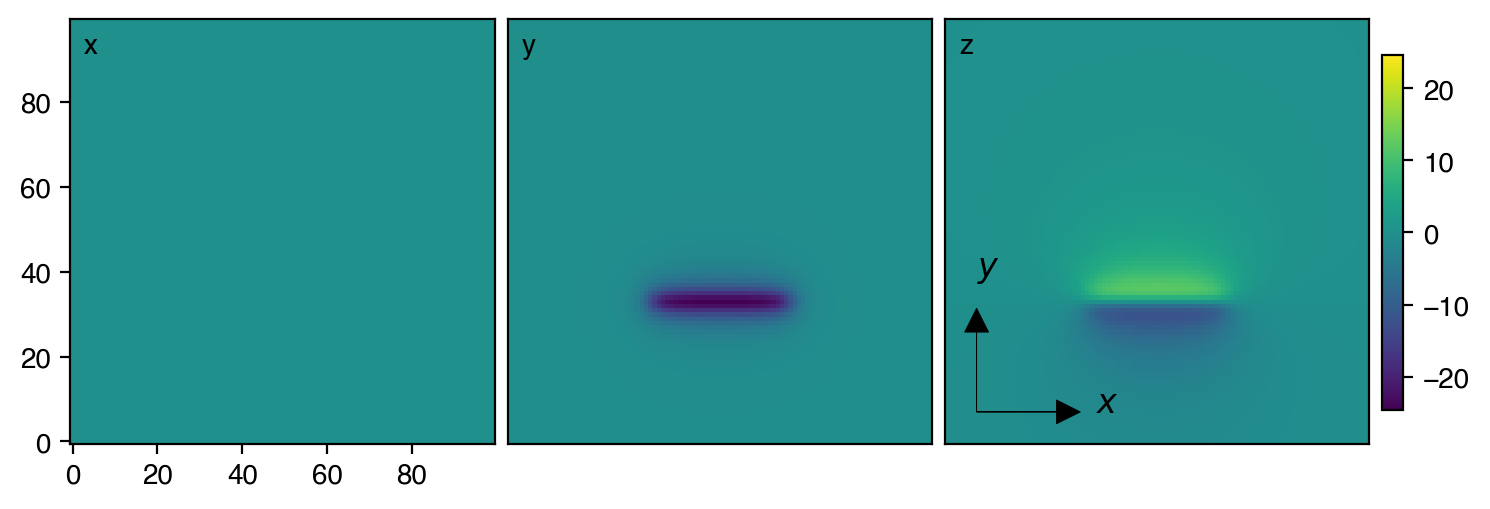

In [61]:
# create another test_path which is just a straight line
def straight_line_path(s):
    # add z coordinate of the path to be z = 0 
    s = torch.cat([s, torch.zeros_like(s[:, :1])], dim=1)
    return s

try:
    wn.net.forward = straight_line_path

    B_straight = wn.get_B(pos=plane_pos)
    B_straight = GridSampler.pts_to_grid(B_straight, 100, 100)

    fig_straight = plot_n_components(B_straight)
finally:
    wn.net.forward = original_forward

plot_n_components(B_straight)

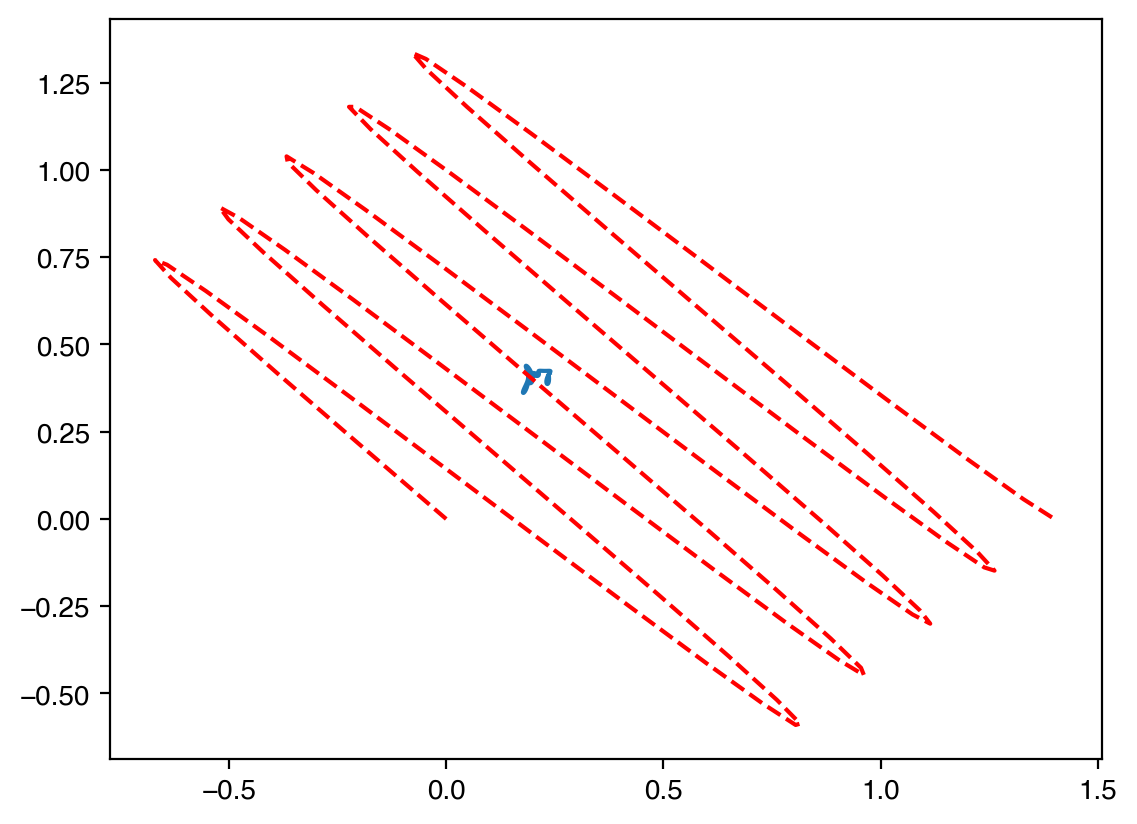

In [39]:
wn.path = test_path
wn.plot_wire()

In [11]:
model = WireNet.load_from_checkpoint(
    __logpath__ / 'wirenet_model_v0' / 'version_1' / 'wirenet-epoch=349-val_loss=0.09.ckpt',
    learnable_I=True,
    strict=False,
    )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['net.shift']


In [13]:
model.net.shift = torch.tensor([0, 0], device=model.device)

In [32]:
torch.onnx.export(model.net, torch.tensor([[0]], device=model.device), __logpath__ / 'wirenet_model_v0' / 'version_1' / 'model.ckpt')

/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/torch/onnx/utils.py:1686: UserWarning: The exported ONNX model failed ONNX shape inference. The model will not be executable by the ONNX Runtime. If this is unintended and you believe there is a bug, please report an issue at https://github.com/pytorch/pytorch/issues. Error reported by strict ONNX shape inference: [ShapeInferenceError] (op_type:Einsum, node name: /ffs.0/Einsum): Inputs has inconsistent type tensor(float) (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391816234/work/torch/csrc/jit/serialization/export.cpp:1421.)
  _C._check_onnx_proto(proto)


In [14]:
model.eval()

WireNet(
  (net): WirePath(
    (ffs): ModuleList(
      (0-2): 3 x GaussianFourierFeaturesTransform()
    )
    (fcn): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=30, out_features=2, bias=True)
    )
  )
)

In [17]:
grid.points

pyvista_ndarray([[-1.        , -1.        ,  0.1       ],
                 [-0.96000004, -1.        ,  0.1       ],
                 [-0.91999996, -1.        ,  0.1       ],
                 ...,
                 [ 2.92      ,  3.        ,  0.1       ],
                 [ 2.96      ,  3.        ,  0.1       ],
                 [ 3.        ,  3.        ,  0.1       ]], dtype=float32)

In [22]:
grid["B_fit"] = model.get_B(grid.points).detach().cpu()

In [23]:
grid.plot(scalars="B_fit")

Widget(value='<iframe src="http://localhost:64184/index.html?ui=P_0x332512140_1&reconnect=auto" class="pyvista…

In [ ]:
MagneticFieldImageData.get_as_grid(grid, "B")

AttributeError: 'ImageData' object has no attribute 'B'

In [25]:
grid.plot(scalars="B")

Widget(value='<iframe src="http://localhost:64184/index.html?ui=P_0x332511450_2&reconnect=auto" class="pyvista…

In [31]:
grid.plot(scalars="B_fit")

Widget(value='<iframe src="http://localhost:64184/index.html?ui=P_0x3eac7d9c0_3&reconnect=auto" class="pyvista…

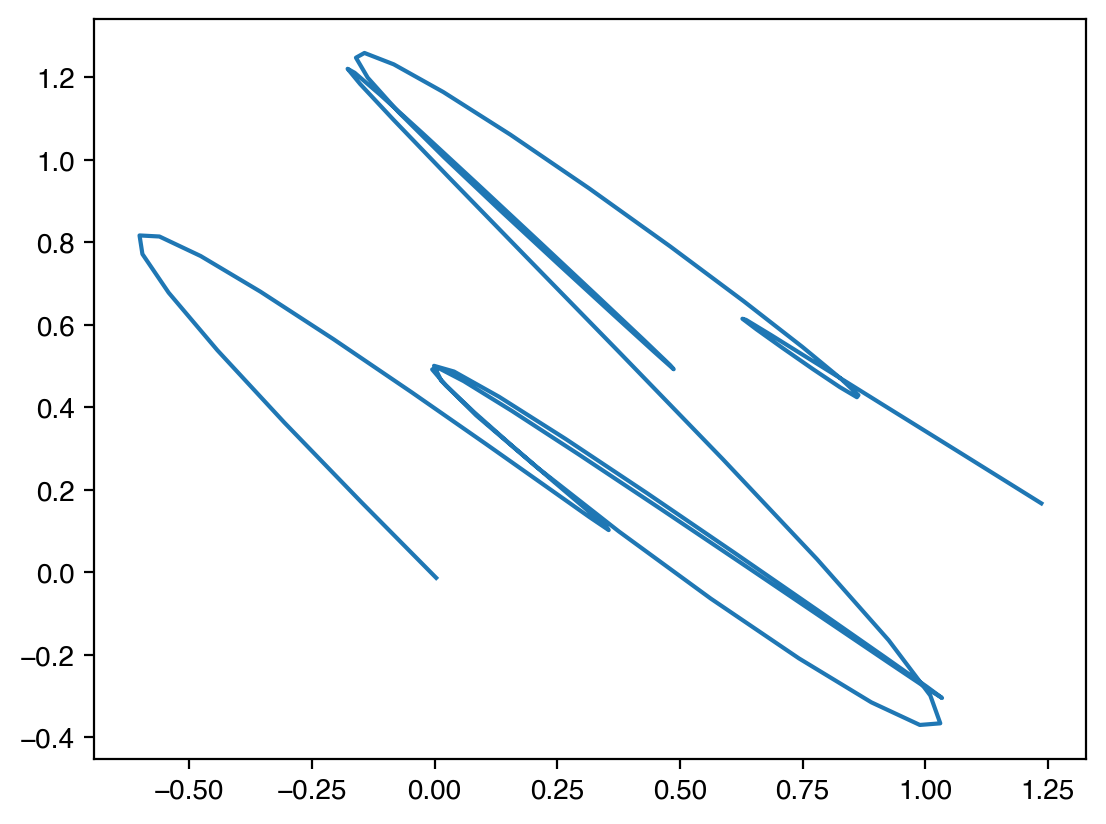

In [22]:
model.plot_wire()

# Profiling

Here I want to profile the PyTorch code for experiments, since, especially `ExperimentDecay` are very slow at ≈ 20 iterations per second. Given that I have a total of 100000 steps, it results in around 2 hours of training. 

For profiling, we will try `Scalene` and the `torch.profiler` module. 

First, starty with `Scalene`:


In [10]:
%load_ext scalene

LOADING
Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version. To profile in line mode, use
`%scrun [options] statement`. To profile in cell mode, use `%%scalene
[options]` followed by your code.

NOTE: in Jupyter notebook on MacOS, Scalene cannot profile child
processes. Do not run to try Scalene with multiprocessing in Jupyter
Notebook.


In [11]:
config = JerschowExperimentConfig('Sine_wire.txt',
                                  model_params=dict(n_inputs=3, n_outputs=3, 
                                                    ff_stds=[(0.1, 10), (2, 5), (3, 5)]),
                                  data_batch_size=1000,
                                  batch_size=1000,
                                  decay_batch_size=2000,
                                  lr=1e-2,
                                  nz_points=100,
                                  eps_curl=1,
                                  eps_data=1,
                                  eps_div=1,)

experiment_decay = JerschowExperimentLearnDecayB(config)

experiment_decay.config.eps_decay = 10
experiment_decay.losses = {
    "total": [],
    "data": [],
    "curl": [],
    "div": [],
    "bd_decay": [],
}